# Covid-19 Forecasting - Data Preparation and Analysis


No contexto do COVID-19 vamos tentar prever o número de pessoas infetadas e o número de fatalidades em Portugal. Numa primeira instância vamos analisar um dataset global e tentar tirar conclusões. Depois de estar concluída a primeira análise vamos reletir sobre o caso português em concreto.

Após a exploração do dataset principal vamos tentar enriquece-lo com algumas features calculadas e tentar chegar a um modelo simples de regressão linear. De seguida iremos otimizar o modelo.

Tendo o modelo de regressão linear construído vamos explorar outros modelos clássicos de ML como SVM e Random Forests.

Por fim, vamos recorrer a RNN's para comparar com os modelos clássicos.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

## **Dataset global**

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25924 entries, 0 to 25923
Data columns (total 34 columns):
iso_code                           25860 non-null object
continent                          25683 non-null object
location                           25924 non-null object
date                               25924 non-null object
total_cases                        25694 non-null float64
new_cases                          25694 non-null float64
total_deaths                       25694 non-null float64
new_deaths                         25694 non-null float64
total_cases_per_million            25630 non-null float64
new_cases_per_million              25630 non-null float64
total_deaths_per_million           25630 non-null float64
new_deaths_per_million             25630 non-null float64
total_tests                        7330 non-null float64
new_tests                          6663 non-null float64
total_tests_per_thousand           7330 non-null float64
new_tests_per_thousand      

Em primeiro, lugar vamos verificar a existência de nulos que possam comprometer a nossa análise. Como podemos verificar com o código descrito abaixo existem bastantes atributos com valores nulos. Muitos deles tem a ver com o facto do país em causa não divulgar este tipo de dados e também pela pandemia não ter começado ao mesmo tempo em todos os sítios. Ao longo da nossa análise iremos trata-los da forma que acharmos mais apropriada, sendo que o próprio dataset tem algumas soluções para certos tipos de nulos, como é o caso do número de casos em alguns países, visto que nem todos divulgam esta contagem todos os dias, por isso o que vem feito já de raiz no dataset é o atributo new_tests_smoothed, onde existe interpolação para não ter espaços com vaores nulos no número de novos testes.

O dataset é bastante extenso e contém um número de features considerável, estando elas explicadas no seguinte link: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data-codebook.md

Vamos então começar por verificar a evolução global dos casos confirmados e dos obitos

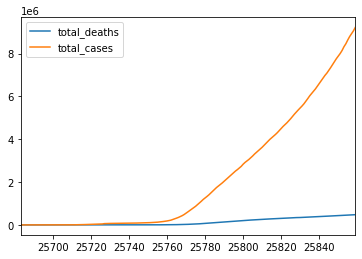

In [4]:
world_total_cases = dataset[dataset['location'] == 'World']['total_cases']
world_total_deaths = dataset[dataset['location'] == 'World']['total_deaths']
pd.DataFrame({'total_deaths': world_total_deaths, 'total_cases':world_total_cases}).plot()

É possível verificar que o crescimento dos casos confirmados é exponencial, estando perto dos 9 milhões, porém e felizmente, o número de fatalidades revela um comportamento bastante mais plano, embora esteja a aumentar. O gráfico parece ter pouca suavidade no início da propagação, o que deverá estar relacionado com o facto de ter tido apenas um foco inicial, sendo ele a China e que a avaliação de doentes infetados tenha sido mais drástica a partir de um certo ponto.

Após esta análise inicial é possível verificar que a epidemia comporta-se de maneira diferente em muitos países. Obviamente que, os números nunca poderiam ser iguais, visto que ela não começou ao mesmo tempo em todos os países, mas também não são iguais devido a um grande número de fatores, entre eles, está a densidade populacional, a idade da população, os níveis sanitários, as medidas de contenção implementadas, testes realizados e até o encobrimento de dados. Como exemplo, podemos analisar os seguinte gráficos.

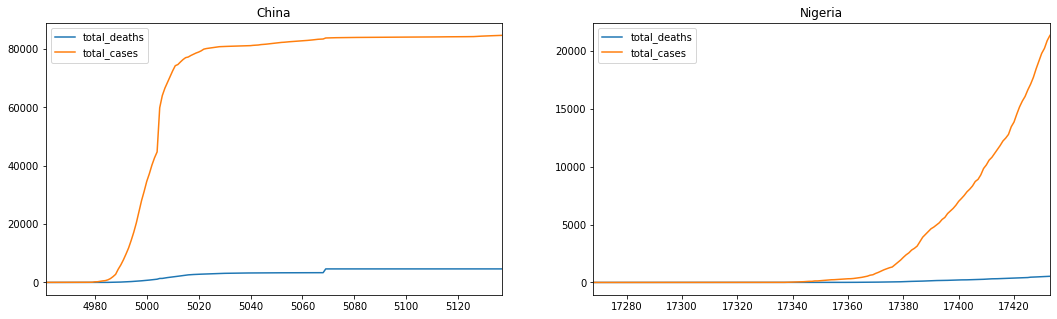

In [5]:
china_total_cases = dataset[dataset['location'] == 'China']['total_cases']
china_total_deaths = dataset[dataset['location'] == 'China']['total_deaths']


nigeria_total_cases = dataset[dataset['location'] == 'Nigeria']['total_cases']
nigeria_total_deaths = dataset[dataset['location'] == 'Nigeria']['total_deaths']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
ax1.set_title("China analysis")
ax2.set_title("Nigeria analysis")
pd.DataFrame({'total_deaths': china_total_deaths, 'total_cases':china_total_cases}).plot(ax=ax1, title='China')
pd.DataFrame({'total_deaths': nigeria_total_deaths, 'total_cases':nigeria_total_cases}).plot(ax=ax2, title='Nigeria')

Nos dois plots anteriores podemos ver dois casos que se revelam anómalos.
Em primeiro lugar, podemos olhar para a Nigeria que é um dos países com maior população do mundo e, apesar de o vírus já ter chegado a este país, ainda foram registados muitos poucos casos. Acreditamos que isto terá a ver com as inúmeras dificuldades sociais e económicas deste país o que torna complicado o acto de diagnosticar/testar e até mesmo registar os casos relacionados com o vírus.

Em segundo lugar, nada mais do que a China que apesar de ter sido o epicentro de tudo e de não estar preparada apenas reporta até à data um máximo de 4638 mortes, como podemos verificar pela tabela seguinte, sendo que o número de casos confirmados ficou bastante estagnado. Com isto, não queremos dizer que a China está a mentir nos seus números, mas é de facto um caso que revela um comportamento diferente do vírus, talvez devido às duras medidas implementadas na província de Wuhan, porém elas foram implementadas um pouco tarde.

Posto isto, não faria muito sentido estar a prever a evolução desta epidemia globalmente e embora pudessemos tentar alinhar os dados dos diferentes países vamo-nos focar num país que tem sido elogiado pelo combate ao COVID-19 e cujas informações apresentadas parecem ser credíveis e que é Portugal. Com algumas pesquisas, encontramos um dataset mais detalhado sobre Portugal e com informações fornecidas pela DGS.

Antes de analisarmos em concreto o caso de Portugal vamos tentar perceber melhor alguns dados que nos são fornecidos vamos por enquanto deixar de parte a série temporal de cada país e focarmo-nos na situação atual e compara-la com alguns indicadores de cada país. 

In [6]:
def transform(dataset):
    i = ['total_deaths_per_million', 'total_cases_per_million',  'stringency_index', 'population_density', 'gdp_per_capita', 'median_age', 'extreme_poverty', 'cvd_death_rate', 'diabetes_prevalence', 'life_expectancy']
    
    special = ['total_tests_per_million','aged_65_older_per_million', 'handwashing_facilities_per_million', 'hospital_beds_per_million', 'smokers_per_million']
    
    res = dict.fromkeys(i+special)

    for column in i:
        if dataset[column].dtype != 'object':
            res[column] = (dataset[column].max())
        else:
            res[column] = (dataset[column])
    
    
    pop = dataset['population'].max()
    
    res['total_tests_per_million'] = dataset['total_tests'].max() * 1e6 / pop
    res['aged_65_older_per_million'] = dataset['aged_65_older'].max() * 1e6
    res['handwashing_facilities_per_million'] = dataset['handwashing_facilities'].max() *  1e6
    res['hospital_beds_per_million'] = dataset['hospital_beds_per_thousand'].max() / 1e3
    res['smokers_per_million'] = ((dataset['female_smokers'].max() + dataset['male_smokers'].max())) * 1e6 / pop
    
    return pd.Series(res)   

In [7]:
max_relevant_values = dataset.groupby(['location']).apply(lambda x : transform(x))

In [8]:
max_relevant_values.head()

,total_deaths_per_million,total_cases_per_million,stringency_index,population_density,gdp_per_capita,median_age,extreme_poverty,cvd_death_rate,diabetes_prevalence,life_expectancy,total_tests_per_million,aged_65_older_per_million,handwashing_facilities_per_million,hospital_beds_per_million,smokers_per_million
location,,,,,,,,,,,,,,,
Afghanistan,15.875,757.315,84.26,54.422,1803.987,18.6,NaN,597.029,9.59,64.83,NaN,2581000.0,37746000.0,0.00050,NaN
Albania,15.637,711.307,89.81,104.871,11803.431,38.0,1.1,304.195,10.08,78.57,NaN,13188000.0,NaN,0.00289,20.258531
Algeria,19.635,275.387,92.13,17.348,13913.839,29.1,0.5,278.364,6.73,76.88,NaN,6211000.0,83741000.0,0.00190,0.709219
Andorra,673.008,11065.812,56.48,163.755,NaN,NaN,NaN,109.135,7.97,83.73,NaN,NaN,NaN,NaN,864.557044
Angola,0.304,5.659,90.74,23.890,5819.495,16.8,NaN,276.045,3.94,61.15,NaN,2405000.0,26664000.0,NaN,NaN


Vamos agora pegar no top 5 de países com mais/menos casos/mortes por milhão e compara-los com os indicadores existentes, para tentar tirar algumas conclusões básicas.

In [9]:
max_relevant_values.apply(lambda x : x.corr(max_relevant_values['total_cases_per_million']))

total_deaths_per_million              0.502756
total_cases_per_million               1.000000
stringency_index                     -0.008338
population_density                    0.097991
gdp_per_capita                        0.610744
median_age                            0.240756
extreme_poverty                      -0.317823
cvd_death_rate                       -0.270009
diabetes_prevalence                   0.129383
life_expectancy                       0.344104
total_tests_per_million               0.488182
aged_65_older_per_million             0.087252
handwashing_facilities_per_million    0.355877
hospital_beds_per_million             0.033511
smokers_per_million                   0.171684
dtype: float64

In [10]:
max_relevant_values.apply(lambda x : x.corr(max_relevant_values['total_deaths_per_million']))

total_deaths_per_million              1.000000
total_cases_per_million               0.502756
stringency_index                     -0.033739
population_density                    0.030096
gdp_per_capita                        0.386338
median_age                            0.389041
extreme_poverty                      -0.263219
cvd_death_rate                       -0.368710
diabetes_prevalence                  -0.115139
life_expectancy                       0.377593
total_tests_per_million               0.184885
aged_65_older_per_million             0.443924
handwashing_facilities_per_million    0.313796
hospital_beds_per_million             0.105668
smokers_per_million                   0.252986
dtype: float64

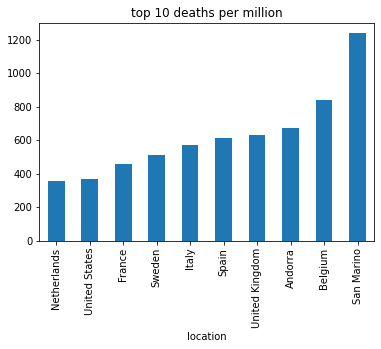

In [11]:
top10_deaths = max_relevant_values.nlargest(10, 'total_deaths_per_million')
top10_deaths['total_deaths_per_million'].sort_values().plot(kind='bar', title='top 10 deaths per million')

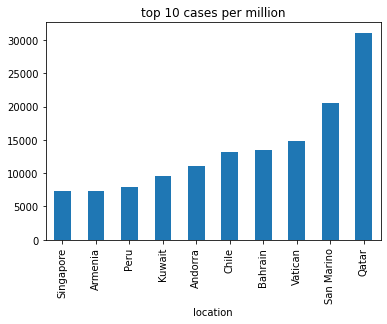

In [12]:
top10_cases = max_relevant_values.nlargest(10, 'total_cases_per_million')
top10_cases['total_cases_per_million'].sort_values().plot(kind='bar',  title='top 10 cases per million')

Mais tarde, voltaremos a pegar neste dataset global no contexto de outros tipos de modelos de machine learning. Posto isto, vamos explorar de seguida um dataset mais detalhado sobre Portugal

## **Dataset de Portugal**

In [13]:
dataset = pd.read_csv("https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv")

### Tratamento de Valores Nulos

Para já vamos converter os NaN para 0, porque correspondem a dias em que não se registaram casos, sendo que isto apenas acontece no inicío da pandemia. Consideramos fazer uma interpolação para não substituir estes valores diretamente por zero, porém como eles são poucos e não se tratam de missing values, mas sim da não existência de casos, logo, numa primeira fase, passarão a ser 0.

In [14]:
dataset = dataset.fillna(0).reset_index(drop='True')

### Exploração Inicial

Vamos então ver com mais detalhe os números portugueses.

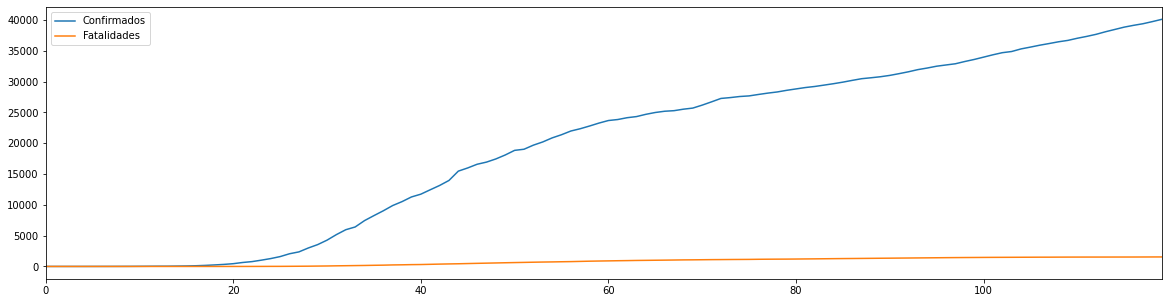

In [15]:
alvos = pd.concat([dataset['confirmados'],dataset['obitos']], axis=1, keys=['Confirmados', 'Fatalidades']).reset_index(drop='True')
alvos.plot(figsize=(20,5))

O plot anterior revela que o paradigma português, no que toca à evolução do vírus, é bastante diferente de casos mais graves, como os da Itália ou EUA, isto porque a curva não aparenta ter um crescimento exponencial, assemelhando-se mais a uma parábola considerávelmente achatada. O número de mortos é bastante reduzido, parecendo até manter-se em 0, mas isso é devido às diferenças de escalas com o número de fatalidades.

Este dataset tem muitos detalhes sobre os números do covid-19 em Portugal, chegando a ter o número de casos confirmados e obitos dividido por idades e sexo. De seguida mostra-mos apenas, como exemplo, estas divisões para os casos confirmados.

In [16]:
dataset[dataset.columns[22:40]].head()

,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


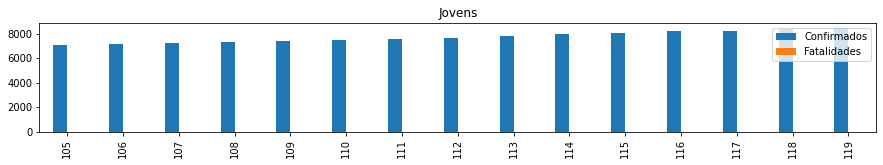

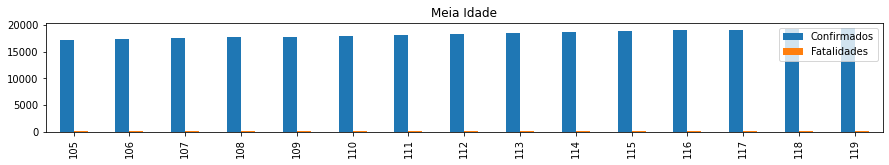

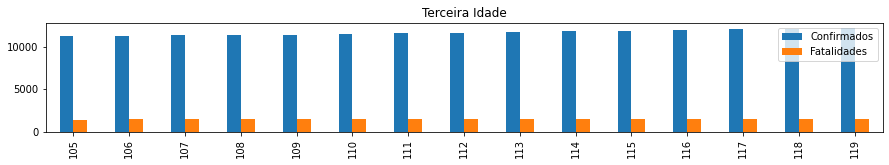

In [17]:
dataset = dataset.reset_index(drop='True')

confirmados_jovens = dataset['confirmados_0_9_m'] + dataset['confirmados_10_19_m'] + dataset['confirmados_20_29_m'] + dataset['confirmados_0_9_f'] + dataset['confirmados_10_19_f'] + dataset['confirmados_20_29_f'] 
fatalidades_jovens = dataset['obitos_0_9_m'] + dataset['obitos_10_19_m'] + dataset['obitos_20_29_m'] + dataset['obitos_0_9_f'] + dataset['obitos_10_19_f'] + dataset['obitos_20_29_f'] 
confirmados_meia_idade = dataset['confirmados_30_39_m'] + dataset['confirmados_40_49_m'] + dataset['confirmados_50_59_m'] + dataset['confirmados_30_39_f'] + dataset['confirmados_40_49_f'] + dataset['confirmados_50_59_f'] 
fatalidades_meia_idade = dataset['obitos_30_39_m'] + dataset['obitos_40_49_m'] + dataset['obitos_50_59_m']+ dataset['obitos_30_39_f'] + dataset['obitos_40_49_f'] + dataset['obitos_50_59_f'] 
confirmados_terceira_idade = dataset['confirmados_60_69_m'] + dataset['confirmados_70_79_m'] + dataset['confirmados_80_plus_m'] + dataset['confirmados_60_69_f'] + dataset['confirmados_70_79_f'] + dataset['confirmados_80_plus_f'] 
fatalidades_terceira_idade = dataset['obitos_60_69_m'] + dataset['obitos_70_79_m'] + dataset['obitos_80_plus_m'] + dataset['obitos_60_69_f'] + dataset['obitos_70_79_f'] + dataset['obitos_80_plus_f'] 


pd.concat([confirmados_jovens,fatalidades_jovens], axis=1, keys=['Confirmados', 'Fatalidades']).tail(15).plot(kind='bar', figsize=(15,2), title='Jovens')
pd.concat([confirmados_meia_idade,fatalidades_meia_idade], axis=1,  keys=['Confirmados', 'Fatalidades']).tail(15).plot(kind='bar', figsize=(15,2), title='Meia Idade')
pd.concat([confirmados_terceira_idade,fatalidades_terceira_idade], axis=1,  keys=['Confirmados', 'Fatalidades']).tail(15).plot(kind='bar', figsize=(15,2), title='Terceira Idade')

Posto isto, e como era de prever, conseguimos verificar que a população da terceira idade é a que gera o maior número de fatalidades, embora não seja a mais afetada pelo contagio.

### Remoção de Atributos Irrelevantes 

É importante logo à partida reduzir o número de atributos relevantes. Iremos, então, retirar algumas colunas desnecessárias como o 'url' que apenas contém a fonte dos dados (relatório DGS), a data do relatório,isto porque iremos referirmo-nos aos casos apenas como uma sequencia a partir do dia 1 (início dos dados) e até ao dia do último dado, os confirmados e mortes por idade, sexo e por regiões, visto que já estarão representados nas colunas principais destes casos.

O dataset também inclui o total de recuperados, mas eles irão ser retirados, porque não serão o nosso foco neste trabalho. A coluna nao_confirmados irá ser retirada, pois não apresenta informação útil, assumindo que estes casos são os que foram testados e acusaram negativo (é esta a nossa interpretação). Os casos 'importados' também não revelam ser um número diferenciador para a previsão e serão removidos.

In [18]:
columns1 = [x for x in range(20, 40)]
columns2 = [x for x in range(2, 11)]
columns3 = [x for x in range(46, 86)]
dataset = dataset.drop(dataset.columns[columns1 + columns2 + columns3], axis=1)
dataset = dataset.drop(['data', 'data_dados', 'n_confirmados', 'recuperados'], axis=1)

### Definição das Variáveis Alvo

O que tornará a previsão mais interessante será lidarmos com variáveis alvo referentes a novos confirmados/obitos e não o seu valor acumulado, para o modelo não seja enganador e não apresente bons resultados ao usar os dados do "dia anterior". Na verdade o dataset já tem uma coluna apenas para os novos confirmados, mas será necessário calcular para os óbitos. 

Para os restantes atributos não serão efetuados estes cálculos, visto que estes valores encontram-se num formato que não o permite, ou seja, são apresentados como um total atual, ou seja e por exemplo, num dado dia quantas pessoas estão à espera de resultados (lab), logo não conseguimos saber quantos novos é que estão à espera, mas sim qual a quantidade que está à espera naquele dia, o que também faz sentido, logo não iremos mexer neste tipo de atributos.

In [19]:
def diff_calc(data, column):
    new_column = column + "_novos"
    data[new_column] = (data[column].shift(0, fill_value=0) - data[column].shift(1, fill_value=0))
    data[new_column] = np.where((data[new_column] < 0),np.nan ,data[new_column])
    
    return data.interpolate(method='linear')

In [20]:
dataset = diff_calc(dataset, 'obitos')
dataset = dataset.drop(['obitos'], axis=1)

dataset = diff_calc(dataset, 'suspeitos')
dataset = dataset.drop(['suspeitos'], axis=1)

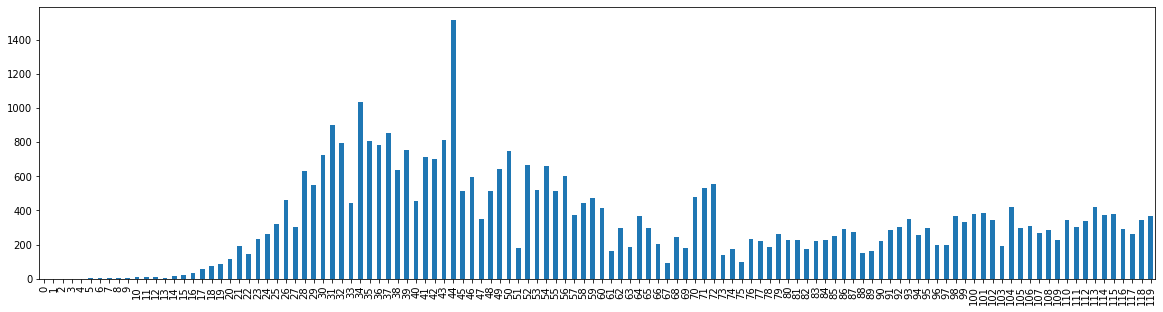

In [21]:
dataset['confirmados_novos'].plot(kind='bar', figsize=(20,5))

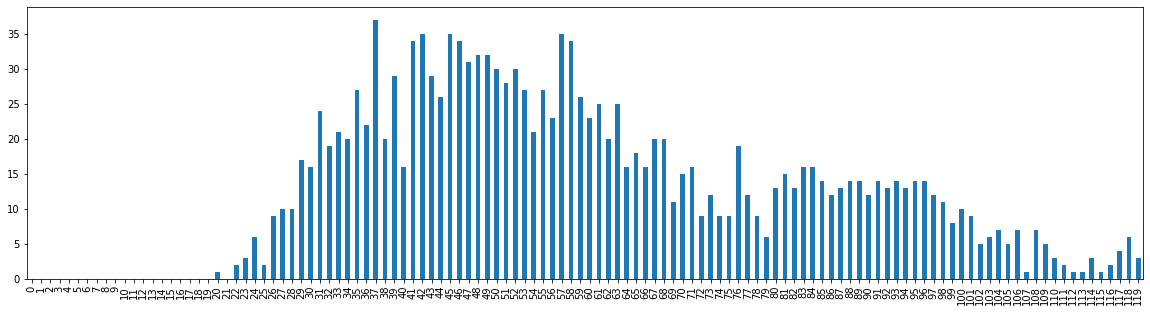

In [22]:
dataset['obitos_novos'].plot(kind='bar', figsize=(20,5))

### Análise dos atributos "sintomas"

<BarContainer object of 6 artists>

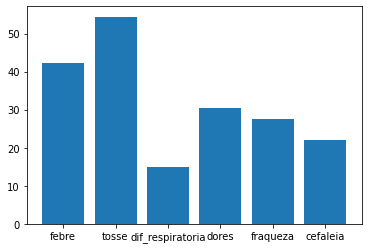

In [23]:
sintomas = []
sintomas.append(dataset['sintomas_febre'].sum())
sintomas.append(dataset['sintomas_tosse'].sum())
sintomas.append(dataset['sintomas_dificuldade_respiratoria'].sum())
sintomas.append(dataset['sintomas_dores_musculares'].sum())
sintomas.append(dataset['sintomas_cefaleia'].sum())
sintomas.append(dataset['sintomas_fraqueza_generalizada'].sum())
plt.bar(['febre', 'tosse', 'dif_respiratoria', 'dores', 'fraqueza', 'cefaleia'], sintomas)

Claramente o maior sintoma é a tosse, porém os restantes também são bastante comuns, sendo o menos comum a dificuldade respiratória que, na nossa opinião, terá a ver com o facto de os sintomas mais comumns serem os sintomas apresentados numa fase inicial da doença e quando é feito o diagnóstico, sendo que a dificuldade respiratória será algo mais característico de fases mais avançadas da doença. 

Para a análise que vamos fazer os sintomas seriam interessantes se os conseguissemos relacionar diretamente com o número de obitos, para ver se pessoas que inicialmente apresentam determinados sintomas morrem/sobrevivem mais, mas isto com os dados presentes é algo praticamente impossível, porque os dados teriam de ter um mapeamente muito mais detalhado, relacionando obito com sintoma inicial, o que algo que não possuímos de momento, levando a um grande erro na nossa opinião, porque a morte de um paciente dependerá de inúmeros fatores.

De seguida temos uma matriz de correlações e onde, claramente, se pode ver que os sintomas apresentam correlações com as variáveis que queremos prever, e até outras features, notoriamente mais fracas que outros preditores.

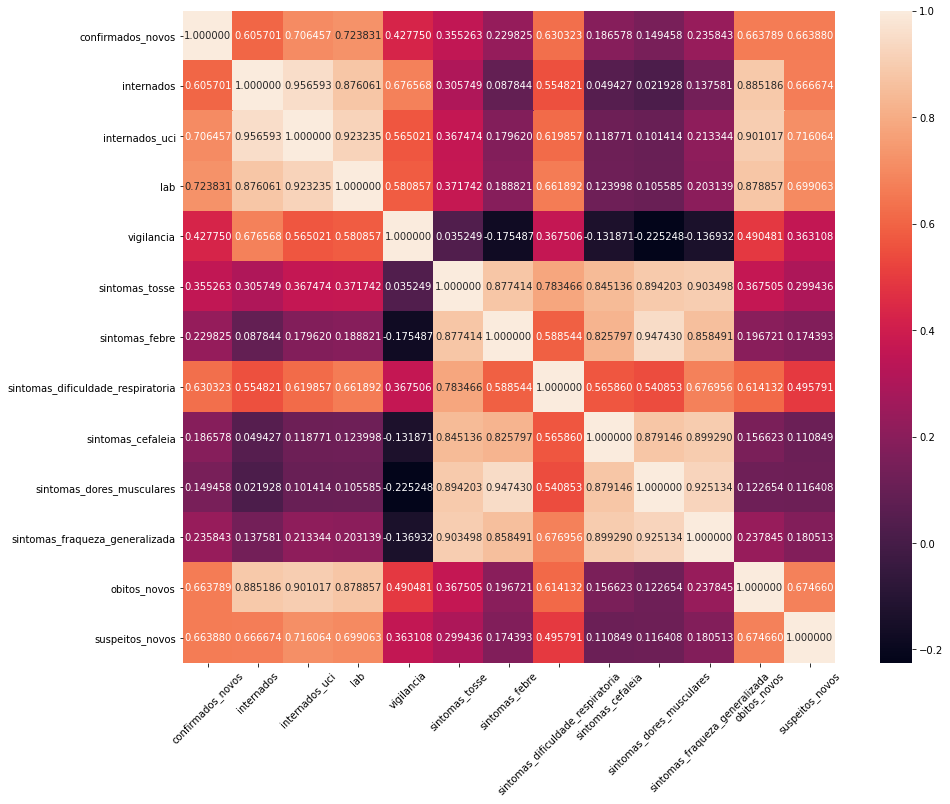

In [24]:
corr = dataset.corr()
plt.figure(figsize=(16,12))
ax = sns.heatmap(corr, square=True, annot=True, fmt='.6f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Vamos proceder então à sua remoção.

In [25]:
columns = ['sintomas_tosse', 'sintomas_febre', 'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia', 'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada']
dataset = dataset.drop(columns, axis=1)

### Remoção das linhas com valores não registados. 

Anteriormente decidimos converter os nulos em zeros, mas como o que queremos prever são séries temporais e sabendo que estes nulos são pequenos e apenas nas primeiras linhas, vamos retira-las, porque podem introduzir algum ruído desnecessário para os nosso modelos. Note-se que apenas retira-mos valores que estão a zero até encontrar-mos algum valor na coluna dos confirmados. Usamos esta coluna, porque os confirmados aparecerão sempre antes de qualquer tipo de fatalidade.

In [26]:
def remove_unregistered_rows(dataset, target):
    to_remove = []
    for index, row in dataset.iterrows(): 
        if row[target] != 0:
            break
        to_remove.append(index)
    return dataset.drop(to_remove)

In [27]:
dataset = remove_unregistered_rows(dataset, 'confirmados_novos')

### Verificação das correlações restantes

De seguida podemos ver as correlações das diferentes colunas com as variáveis a prever. Algumas correlações são baixas, mas não iremos remover atributos por causa deste fator para já, porque posteriormente na construção e análise do modelo estes podem vir a ser úteis, quando em conjunto com outros.

In [28]:
dataset[dataset.columns].corr()['obitos_novos']

confirmados_novos    0.639466
internados           0.877386
internados_uci       0.894022
lab                  0.870323
vigilancia           0.438154
obitos_novos         1.000000
suspeitos_novos      0.658319
Name: obitos_novos, dtype: float64

In [29]:
dataset[dataset.columns].corr()['confirmados_novos']

confirmados_novos    1.000000
internados           0.569965
internados_uci       0.682854
lab                  0.699570
vigilancia           0.358232
obitos_novos         0.639466
suspeitos_novos      0.646286
Name: confirmados_novos, dtype: float64

Pela análise das correlações podemos ver que os óbitos têm mais fortes correlações com os restantes atributos do que os casos confirmados, mas estes também tem alguns atributos que parecem ser relevantes, destacando-se o lab. Vamos agora tentar melhorar um pouco estas relações enriquecendo o dataset. 

### **Enriquecimento do Dataset de Portugal**

Embora seja difícil com os dados que temos estimar, em média, quanto tempo uma pessoa que faleceu permaneceu viva desde o momento em que foi diagnosticada e mesmo conseguindo o intervalo seria grande, o mesmo não se aplica ao periodo de incubação que está definido entre 1 a 14 dias. A comunidade científica não tem certezas quanto a este tempo, podendo haver flutuações no máximo de tempo que pode demorar a demonstrar sintomas, mas de momento é uma das poucas informações consencuais que existem sobre o vírus. Posto isto, vamos tentar analisar o restante dataset de acordo com este dado.

Primeiro podemos abordar as colunas 'suspeitos', 'aguarda_resultado' e 'em_vigilancia', sendo que elas caem todas na mesma categoria que é a de serem um subconjunto dos casos confirmados. Embora muitos indivíduos destas categorias não estejam infetados, alguns deles podem, num futuro próximo, vir a fazer parte do grupo dos confirmados, por isso são colunas a ter em consideração. Em segundo lugar temos as colunas 'internados' e 'internados_uci' estando estas relacionadas mais com o número de obitos.

Para que isto tudo faça sentido temos de falar sobre o conceito de lags. Uma das dificuldades em prever os números desta pandemia é que observações registadas no dia X só terão impacto visível no dia X+N, podendo ser o N o periodo de incubação do vírus, ou o tempo que demora alguém contagiado a falecer. Por isso, temos de arranjar maneira de manter os valores antigos para os poder relacionar com os mais novos em relação aos anteriores. Para este efeito iremos utilizar os lags que são uma maneira de manter o valor anterior de uma coluna, introduzindo-o numa nova coluna, fazendo, basicamente, um 'shift' nos dados. 

In [30]:
def lag_calc(data, minimum, size, column):
    for lag in range(minimum, size + 1):
        lag_column = column + "_lag_" + str(lag)
        data[lag_column] = data[column].shift(lag, fill_value=0)
    return data

In [31]:
def showCorr(pivot, target, sufix, low, high):
    print('\nPivot: ' + pivot + ', Target: ' + target + '\n')
    print('normal: ',dataset[target].corr(dataset[pivot]))
    for i in range(low, high + 1):
        count = str(i)
        print(sufix + ' ' + count + ': ', dataset[target + '_' + sufix + '_' + count].corr(dataset[pivot]))   

Tendo o conceito de lag claro, vamos proceder a utilizar este cálculo para certas colunas. Vejamos então caso a caso.

Aguarda resultados: A receção de um resultado de um teste ao COVID-19 pode resultar num caso confirmado, sendo que o tempo desta receção poderá variar consoante o congestionamento do serviço de análises. Iremos tomar o princípio de que não deverá demorar mais do que 2 dias, portanto esta coluna irá dar origem a mais duas. A primeira tendo os valores da coluna em questão, mas com o 'shifts' de um dia e a segunda com um 'shift' de dois dias. Neste caso, não houve aumento na correlação, mas as variáveis podem vir a tornar-se úteis mais tarde nos modelos de ML.

In [32]:
dataset = lag_calc(dataset, 1, 2, 'lab')

showCorr('confirmados_novos', 'lab', 'lag', 1, 2)


Pivot: confirmados_novos, Target: lab

normal:  0.6995696090561458
lag 1:  0.6578433053048526
lag 2:  0.6350670623170428


Suspeitos e em vigilância: Estas duas colunas representam pessoas que poderão vir a ter o vírus, sendo que os suspeitos são aqueles que estão a demonstrar sintomas da doença, mas ainda não foram testados e em vigilância são as pessoas que estiveram numa situação que pudesse ter levado ao possível contagio. Com isto iremos tomar em conta os 14 dias de incubação e numa primeira análise iremos ficar pelo meio, ou seja, iremos calcular o lag destes casos para 8 dias, numa primeira fase.

In [33]:
dataset = lag_calc(dataset, 1, 8, 'suspeitos_novos')
dataset = lag_calc(dataset, 1, 8, 'vigilancia')

Vejamos as novas correlações dos atributos calculados com as variáveis a prever

In [34]:
showCorr('obitos_novos', 'suspeitos_novos', 'lag', 1, 8)
showCorr('confirmados_novos', 'suspeitos_novos', 'lag', 1, 8)


Pivot: obitos_novos, Target: suspeitos_novos

normal:  0.6583194006579328
lag 1:  0.6468623442505541
lag 2:  0.6692885204611628
lag 3:  0.6797456131652597
lag 4:  0.7424129463939345
lag 5:  0.7148259347341122
lag 6:  0.6624356995544677
lag 7:  0.6407669916908396
lag 8:  0.6349054270407194

Pivot: confirmados_novos, Target: suspeitos_novos

normal:  0.6462856217359528
lag 1:  0.6363949896865273
lag 2:  0.48887979764577044
lag 3:  0.5213250135782275
lag 4:  0.39353594163911426
lag 5:  0.39271489764494394
lag 6:  0.42847174437539093
lag 7:  0.3919439440791
lag 8:  0.30258817354250767


In [35]:
showCorr('obitos_novos', 'vigilancia', 'lag', 1, 8)
showCorr('confirmados_novos', 'vigilancia', 'lag', 1, 8)


Pivot: obitos_novos, Target: vigilancia

normal:  0.4381535021707594
lag 1:  0.4354381081271944
lag 2:  0.4227235726058505
lag 3:  0.4130035136297443
lag 4:  0.39283350748409057
lag 5:  0.3909782027364477
lag 6:  0.3683723607999508
lag 7:  0.3587818230598798
lag 8:  0.3277466813897009

Pivot: confirmados_novos, Target: vigilancia

normal:  0.3582323605560633
lag 1:  0.316435993099424
lag 2:  0.2930558071488076
lag 3:  0.2835828228224112
lag 4:  0.2604752535069168
lag 5:  0.2527883736656063
lag 6:  0.23064054674459902
lag 7:  0.21273188631572537
lag 8:  0.18027222129502385


Neste caso apenas tivemos bons resultados para os novos suspeitos e em relação aos óbitos. Vamos fazer o mesmo que no caso anterior para os obitos_novos, confirmados_novos, para trazer os valores antigos para a "frente".

In [36]:
dataset = lag_calc(dataset, 1, 8, 'obitos_novos')
dataset = lag_calc(dataset, 1, 8, 'confirmados_novos')

In [37]:
showCorr('obitos_novos', 'obitos_novos', 'lag', 1, 8)
showCorr('obitos_novos', 'confirmados_novos', 'lag', 1, 8)
showCorr('confirmados_novos', 'confirmados_novos', 'lag', 1, 8)


Pivot: obitos_novos, Target: obitos_novos

normal:  0.9999999999999998
lag 1:  0.9002278329632021
lag 2:  0.9071276953244551
lag 3:  0.8689179500425808
lag 4:  0.8802838893152735
lag 5:  0.8465603968482711
lag 6:  0.8253771450317343
lag 7:  0.7754761516768883
lag 8:  0.7643577010152759

Pivot: obitos_novos, Target: confirmados_novos

normal:  0.6394655144589456
lag 1:  0.6759797986878392
lag 2:  0.6968966098400177
lag 3:  0.7405952958727446
lag 4:  0.7255708858579103
lag 5:  0.7701339401014381
lag 6:  0.7379711140011476
lag 7:  0.7541101823657969
lag 8:  0.7431077001844673

Pivot: confirmados_novos, Target: confirmados_novos

normal:  1.0
lag 1:  0.7280372202136387
lag 2:  0.7268621428572609
lag 3:  0.6434239897055631
lag 4:  0.6364154619285908
lag 5:  0.6473723109557673
lag 6:  0.6700720862275348
lag 7:  0.5771826770144853
lag 8:  0.5759507316170085


Com a introdução de lags na variável confirmados_novos não só nos permite usar estes atributos para a prever, assim como no caso dos lags calculados para os obitos_novos, como permite-nos utiliza-los para prever, também, os novos óbitos. Como podemos constatar pelas correlações apresentadas nos prints anteriores os novos óbitos apresentam correlações mais fortes com os lags da variável confirmados_novos do que com ela no seu estado normal.

No caso dos internados e internados_uci não iremos fazer cálculos, visto que a correlação com o número de obitos já é bastante elevada (> 80) e porque são variáveis um pouco incertas, porque não sabemos em média quanto tempo leva uma pessoa que esteja internada a falecer, se for esse o caso.

Outro conceito que podemos introduzir é o tendència de um valor de um certo dia para outro da mesma coluna. E pode ser definida pelo seguinte método:

In [38]:
def trend_calc(data, minimum, size, column):
    for t in range(minimum, size+1):
        trend_column = column + "_trend_" + str(t)
        data[trend_column] = (data[column].shift(0, fill_value=0) - data[column].shift(t, fill_value=0))/data[column].shift(t, fill_value=0)
    return data

De momento só iremos calcular tendências para os confirmados e para os obitos de cada dataset, seguindo os mesmos princípios do cálculo dos lags, vamos agora calcular tendencias de 15 dias, com um timestep de 15 dias também, ficando assim com tendencias do dia 15 até 30 de relativamente a cada linha.

In [39]:
dataset = trend_calc(dataset, 15, 31, 'obitos_novos')
dataset = dataset.fillna(0)
dataset.replace([np.inf], 0, inplace=True)
dataset = trend_calc(dataset, 15, 31, 'confirmados_novos')

In [40]:
dataset = dataset.replace(np.inf, 0)
dataset = dataset.replace(np.inf, 0)
dataset = dataset.fillna(0).reset_index(drop='True')
dataset = dataset.fillna(0).reset_index(drop='True')

In [41]:
showCorr('obitos_novos', 'obitos_novos', 'trend', 15, 31)
showCorr('obitos_novos', 'confirmados_novos', 'trend', 15, 31)
showCorr('confirmados_novos', 'confirmados_novos', 'trend', 15, 31)


Pivot: obitos_novos, Target: obitos_novos

normal:  0.9999999999999998
trend 15:  0.327104966136539
trend 16:  0.30727989968523656
trend 17:  0.3859654432850984
trend 18:  0.3252941144376998
trend 19:  0.3788491109351857
trend 20:  0.37374500850178555
trend 21:  0.379681425958239
trend 22:  0.3835366073063342
trend 23:  0.3879849549758418
trend 24:  0.3624781601099335
trend 25:  0.3758502741775939
trend 26:  0.3603263051316251
trend 27:  0.3465373184584723
trend 28:  0.3291237638566121
trend 29:  0.31384612357059205
trend 30:  0.31490889927253307
trend 31:  0.2800856734699459

Pivot: obitos_novos, Target: confirmados_novos

normal:  0.6394655144589456
trend 15:  -0.12538308707244927
trend 16:  -0.0855316226903438
trend 17:  -0.050785678931988355
trend 18:  0.018875050374826008
trend 19:  0.007359655579157008
trend 20:  0.030785573188905974
trend 21:  0.07318324192501668
trend 22:  0.15022917797260515
trend 23:  0.1510924043321542
trend 24:  0.2532330543494806
trend 25:  0.204663711316

Estes cálculos não parecem fornecer muito ganho, mas poderão vir a ser úteis para o modelo.

## **Guardar os datasets gerados**

In [42]:
dataset.to_csv("modified_dataset.csv", index = "False")